# Exploring (de)compaction with Python

#### Zoltán Sylvester, Bureau of Economic Geology, The University of Texas at Austin

All clastic sediments are subject to compaction (and reduction of porosity) as the result of increasingly tighter packing of grains under a thickening overburden. Decompaction - the estimation of the decompacted thickness of a rock column - is an important part of subsidence (or geohistory) analysis. The following exercise is loosely based on the excellent basin analysis textbook by Allen & Allen (2013), especially their Appendix 56.

## Import stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functools
from scipy.optimize import bisect
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['mathtext.fontset'] = 'cm'

## Posing the problem

Given a sediment column of a certain lithology with its top at $y_1$ and its base at $y_2$, we are trying to find the thickness and average porosity of the same sediment column at a different depth (see figure below). We are going to set the new top $y_1'$ and work towards finding the new base $y_2'$.

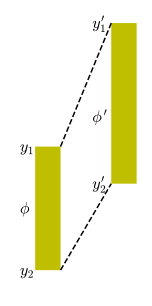

In [2]:
plt.figure(figsize=(2,5))
x = [0,1,1,0,0]
y = [1,1,1.5,1.5,1]
plt.text(-0.6,1.02,'$y_1$',fontsize=16)
plt.text(-0.6,1.52,'$y_2$',fontsize=16)
plt.text(-0.6,1.27,'$\phi$',fontsize=16)
plt.fill(x,y,'y')
x = [3,4,4,3,3]
y = [0.5,0.5,1.15,1.15,0.5]
plt.text(2.25,0.52,'$y_1\'$',fontsize=16)
plt.text(2.25,1.17,'$y_2\'$',fontsize=16)
plt.text(2.25,0.9,'$\phi\'$',fontsize=16)
plt.fill(x,y,'y')
plt.plot([1,3],[1,0.5],'k--')
plt.plot([1,3],[1.5,1.15],'k--')
plt.gca().invert_yaxis()
plt.axis('off');

## Porosity decrease with depth

Porosity decreases with depth, initially largely due to mechanical compaction of the sediment. The decrease in porosity is relatively large close to the seafloor, where sediment is loosely packed; the lower the porosity, the less room there is for further compaction. This decrease in porosity with depth is commonly modeled as a negative exponential function (Athy, 1930):

$$ \phi(y) = \phi_0 e^{-\frac{y}{y_0}} $$

where $\phi(y)$ is the porosity at depth $y$ and $y_0$ is the depth where the initial porosity $\phi_0$ was reduced by $1/e$.

This is an empirical equation, as there is no direct physical link between depth and porosity; compaction and porosity reduction are more directly related to the increase in effective stress under a thicker overburden. Here we only address the simplest scenario with no overpressured zones. For normally pressured sediments, Athy's porosity-depth relationship can be expressed in a slightly different form:

$$ \phi(y) = \phi_0 e^{-cy} $$

where $c$ is a coefficient with the units $km^{-1}$. The idea is that $c$ is a characteristic constant for a certain lithology and it can measured if porosity values are available from different depths. Muds have higher porosities at the seafloor than sands but they compact faster than sands. The plot below show some typical curves that illustrate the exponential decrease in porosity with depth for sand and mud. The continuous lines correspond to the parameters for sand and mud in Appendix 56 of Allen & Allen (2013); the dashed lines are exponential fits to data from the Ocean Drilling Program (Kominz et al., 2011).

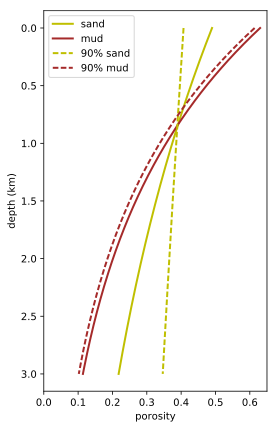

In [3]:
c_sand = 0.27 # porosity-depth coefficient for sand (km-1)
c_mud = 0.57 # porosity-depth coefficent for mud (km-1) 
phi_sand_0 = 0.49 # surface porosity for sand
phi_mud_0 = 0.63 # surface porosity for mud
y = np.arange(0,3.01,0.01)

phi_sand = phi_sand_0 * np.exp(-c_sand*y)
phi_mud = phi_mud_0 * np.exp(-c_mud*y)

plt.figure(figsize=(4,7))
plt.plot(phi_sand,y,'y',linewidth=2,label='sand')
plt.plot(phi_mud,y,'brown',linewidth=2,label='mud')
plt.xlabel('porosity')
plt.ylabel('depth (km)')
plt.xlim(0,0.65)
plt.gca().invert_yaxis()

c_sand = 1000/18605.0 # Kominz et al. 2011 >90% sand curve
c_mud = 1000/1671.0 # Kominz et al. 2011 >90% mud curve
phi_sand_0 = 0.407 # Kominz et al. 2011 >90% sand curve
phi_mud_0 = 0.614 # Kominz et al. 2011 >90% mud curve
phi_sand = phi_sand_0 * np.exp(-c_sand*y)
phi_mud = phi_mud_0 * np.exp(-c_mud*y)
plt.plot(phi_sand,y,'y--',linewidth=2,label='90% sand')
plt.plot(phi_mud,y,'--',color='brown',linewidth=2,label='90% mud')
plt.legend(loc=0, fontsize=10);

While the compaction trends for mud happen to be fairly similar in the plot above, the ones for sandy lithologies are very different. This highlights that porosity-depth curves vary significantly from one basin to another, and are strongly affected by overpressures and exhumation. Using local data and geological information is critical. As Giles et al. (1998) have put it, "The use of default compaction curves can introduce significant errors into thermal history and pore- fluid pressure calculations, particularly where little well data are available to calibrate the model." To see how widely - and wildly - variable compaction trends can be, check out the review paper by Giles et al. (1998).

## Deriving the general decompaction equation 

Compacting or decompacting a column of sediment means that we have to move it along the curves in the figure above. Let's consider the volume of water in a small segment of the sediment column (over which porosity does not vary a lot):

$$ dV_w = \phi dV_t $$

As we have seen before, porosity at depth $y$ is

$$ \phi(y) = \phi_0 e^{-cy} $$ 

The first equation then becomes

$$ dV_w = \phi_0 e^{-cy} dV_t $$

But 

$$ dV_w = A dy_w $$

and

$$ dV_t = A dy_t $$

where $y_w$ and $y_t$ are the thicknesses that the water and total volumes occupy respectively, and $A$ is the area of the column we are looking at. So the relationship is equivalent to

$$ dy_w = \phi_0 e^{-cy} dy_t $$

If we integrate this over the interval $y_1$ to $y_2$ we get

$$ y_w = \int_{y1}^{y2} \phi_0 e^{-cy} dy_t $$

Integrating this yields

$$ y_w = \phi_0 \Bigg(\frac{1}{-c}e^{-cy_2} - \frac{1}{-c}e^{-cy_1}\Bigg) = \frac{\phi_0}{c} \big(e^{-cy_1}-e^{-cy_2}\big) $$

As the total thickness equals the sediment thickness plus the water "thickness", we get

$$ y_s = y_t - y_w = y_2 - y_1 - y_w = y_2 - y_1 - \frac{\phi_0}{c} \big(e^{-cy_1}-e^{-cy_2}\big) $$

The decompacted value of $y_w$ is

$$ y_w' = \frac{\phi_0}{c} \big(e^{-cy_1'}-e^{-cy_2'}\big) $$

Now we can write the general decompaction equation:

$$ y_2'-y_1' = y_s+y_w'  $$

That is,

$$ y_2'-y_1' = y_2 - y_1 - \frac{\phi_0}{c} \big(e^{-cy_1}-e^{-cy_2}\big) + \frac{\phi_0}{c} \big(e^{-cy_1'}-e^{-cy_2'}\big) $$

The average porosity at the new depth will be

$$ \phi = \frac{Ay_w'}{Ay_t'} = \frac{\phi_0}{c}\frac{\big(e^{-cy_1'}-e^{-cy_2'}\big)}{y_2'-y_1'}  $$

## Write code to compute (de)compacted thickness

The decompaction equation could be solved in the 'brute force' way, that is, by gradually changing the value of $y_2'$ until the right hand side (RHS) of the equation is the same as the left hand side (LHS) - see for example the Excel spreadsheet that accompanies Appendix 56 in Allen & Allen (2013). However, we (and scipy) can do better than that; we will use bisection, one the simplest optimization methods to find the root of the function that we set up as RHS-LHS.

In [15]:
# compaction function - the unknown variable is y2a
def comp_func(y2a,y1,y2,y1a,phi,c):
    # left hand side of decompaction equation:
    LHS = y2a - y1a
    # right hand side of decompaction equation:
    RHS = y2 - y1 - (phi/c)*(np.exp(-c*y1)-np.exp(-c*y2)) + (phi/c)*(np.exp(-c*y1a)-np.exp(-c*y2a))
    return LHS - RHS

Now we can do the calculations; here we set the initial depths of a sandstone column $y_1,y_2$ to 2 and 3 kilometers, and we estimate the new thickness and porosity assuming that the column is brought to the surface ($y_1'=0$).

In [16]:
c_sand = 0.27 # porosity-depth coefficient for sand (km-1)
phi_sand = 0.49 # surface porosity for sand
y1 = 2.0 # top depth in km
y2 = 3.0 # base depth in km
y1a = 0.0 # new top depth in km

One issue we need to address is that 'comp_func' six input parameters, but the scipy 'bisect' function only takes one parameter. We create a partial function 'comp_func_1' in which the only variable is 'y2a', the rest are treated as constants:

In [17]:
comp_func_1 = functools.partial(comp_func, y1=y1, y2=y2, y1a=y1a, phi=phi_sand, c=c_sand)
y2a = bisect(comp_func_1,y1a,y1a+3*(y2-y1)) # use bisection to find new base depth
phi = (phi_sand/c_sand)*(np.exp(-c_sand*y1)-np.exp(-c_sand*y2))/(y2-y1) # initial average porosity
phia = (phi_sand/c_sand)*(np.exp(-c_sand*y1a)-np.exp(-c_sand*y2a))/(y2a-y1a) # new average porosity

print('new base depth: '+str(round(y2a,2))+' km')
print('initial thickness: '+str(round(y2-y1,2))+' km')
print('new thickness: '+str(round(y2a-y1a,2))+' km')
print('initial porosity: '+str(round(phi,3)))
print('new porosity: '+str(round(phia,3)))

new base depth: 1.28 km
initial thickness: 1.0 km
new thickness: 1.28 km
initial porosity: 0.25
new porosity: 0.414


## Write code to (de)compact stratigraphic column with multiple layers

Next we write a function that does the depth calculation for more than one layer in a sedimentary column:

In [18]:
def decompact(tops,lith,new_top,phi_sand,phi_mud,c_sand,c_mud):
    tops_new = [] # list for decompacted tops
    tops_new.append(new_top) # starting value
    for i in range(len(tops)-1):
        if lith[i] == 0:
            phi = phi_mud; c = c_mud
        if lith[i] == 1:
            phi = phi_sand; c = c_sand
        comp_func_1 = functools.partial(comp_func,y1=tops[i],y2=tops[i+1],y1a=tops_new[-1],phi=phi,c=c)
        base_new_a = tops_new[-1]+tops[i+1]-tops[i]
        base_new = bisect(comp_func_1, base_new_a, 4*base_new_a) # bisection
        tops_new.append(base_new)
    return tops_new

Let's use this function to decompact a simple stratigraphic column that consists of 5 alternating layers of sand and mud.

In [26]:
tops = np.array([1.0,1.1,1.15,1.3,1.5,2.0])
lith = np.array([0,1,0,1,0]) # lithology labels: 0 = mud, 1 = sand
phi_sand_0 = 0.49 # surface porosity for sand
phi_mud_0 = 0.63 # surface porosity for mud
c_sand = 0.27 # porosity-depth coefficient for sand (km-1)
c_mud = 0.57 # porosity-depth coefficent for mud (km-1) 
tops_new = decompact(tops,lith,0.0,phi_sand_0,phi_mud_0,c_sand,c_mud) # compute new tops

Plot the results:

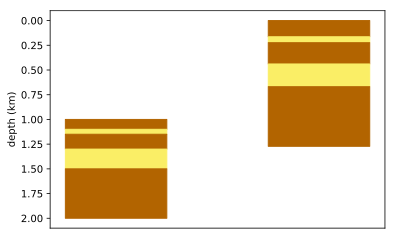

In [30]:
def plot_decompaction(tops,tops_new):
    for i in range(len(tops)-1):
        x = [0,1,1,0]
        y = [tops[i], tops[i], tops[i+1], tops[i+1]]
        if lith[i] == 0:
            color = 'xkcd:umber'
        if lith[i] == 1:
            color = 'xkcd:yellowish'
        plt.fill(x,y,color=color)
        x = np.array([2,3,3,2])
        y = np.array([tops_new[i], tops_new[i], tops_new[i+1], tops_new[i+1]])
        if lith[i] == 0:
            color = 'xkcd:umber'
        if lith[i] == 1:
            color = 'xkcd:yellowish'
        plt.fill(x,y,color=color)
    plt.gca().invert_yaxis()
    plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    plt.ylabel('depth (km)');
    
plot_decompaction(tops,tops_new)

Now let's see what happens if we use the 90% mud and 90% sand curves from Komminz et al. (2011). 

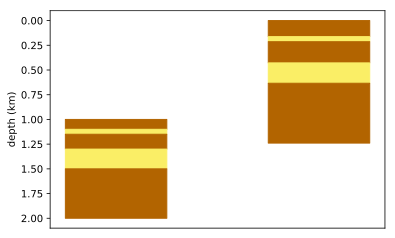

In [31]:
tops = np.array([1.0,1.1,1.15,1.3,1.5,2.0])
lith = np.array([0,1,0,1,0]) # lithology labels: 0 = mud, 1 = sand
c_sand = 1000/18605.0 # Kominz et al. 2011 >90% sand curve
c_mud = 1000/1671.0 # Kominz et al. 2011 >90% mud curve
phi_sand_0 = 0.407 # Kominz et al. 2011 >90% sand curve
phi_mud_0 = 0.614 # Kominz et al. 2011 >90% mud curve
tops_new = decompact(tops,lith,0.0,phi_sand_0,phi_mud_0,c_sand,c_mud) # compute new tops

plot_decompaction(tops,tops_new)

Quite predictably, the main difference is that the sand layers have decompacted less in this case.

That's it for now. It is not that hard to modify the code above for more than two lithologies. Happy (de)compacting!

## References

Allen, P. A., and Allen, J. R. (2013) Basin Analysis: Principles and Application to Petroleum Play Assessment, Wiley-Blackwell.

Athy, L.F. (1930) Density, porosity and compaction of sedimentary rocks. American Association Petroleum Geologists Bulletin, v. 14, p. 1–24.

Giles, M.R., Indrelid, S.L., and James, D.M.D., 1998, Compaction — the great unknown in basin modelling: Geological Society London Special Publications, v. 141, no. 1, p. 15–43, doi: 10.1144/gsl.sp.1998.141.01.02.

Kominz, M.A., Patterson, K., and Odette, D., 2011, Lithology Dependence of Porosity In Slope and Deep Marine Sediments: Journal of Sedimentary Research, v. 81, no. 10, p. 730–742, doi: 10.2110/jsr.2011.60.